In [1]:

# import module list is independent on respective file.
import yfinance as yf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt



from datetime import datetime as dt
from datetime import date as date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from tqdm.notebook import tqdm
from scipy.stats import mstats
import japanize_matplotlib

import os

In [2]:
tickers = pd.read_csv('Code/TOPIXcodelist.csv', index_col=0)['Code']

In [3]:
#tickers2=pd.read_csv('Code/JPNK400.csv', index_col=0)['0'].to_list()
tickers3=pd.read_csv('Code/TOPIXCore.csv', index_col=0, names=['a', '0'])['0'].to_list()
tickers4=pd.read_csv('Code/TOPIXLarge.csv', index_col=0)['0'].to_list()
tickers5 = tickers3+tickers4
tickers6=pd.read_csv('Code/Nikkei225codelist.csv')['Code'].to_list()
tickers7 = pd.read_csv('Code/TOPIXMid.csv', index_col=0, header=None)[1].map(lambda x:str(x)+'.T').to_list()
tickers8 = tickers5 + tickers7

In [8]:
# data2=data2.swaplevel(0,1,axis=1).sort_index(axis=1)[ticker_name]

# いきなり板情報からつかむのも厳しいので、分足レベルで調査してみる。


In [ ]:
#tickers = list(tickers.apply(lambda x:str(x)+ '.T'))
#tickers2 = list(tickers2.apply(lambda x:str(x)+ '.T'))

In [4]:
temp = pd.read_csv(f'Price/TOPIX/{tickers5[-1].replace(".T", "")}.csv', index_col='Date', parse_dates=True)
temp[['macdhist']].describe()

,macdhist
count,28.000000
mean,-176.526612
std,129.328737
min,-350.436564
25%,-273.272230
50%,-206.559512
75%,-46.716293
max,95.904865


In [5]:
import backtrader as bt
import pandas as pd
import numpy as np
from dataclasses import dataclass
from datetime import datetime, date, time as dtime
import time as time_module
from IPython.display import clear_output

TECHNICAL_DATA = {}

def load_technical_once(symbol, column='rsi9'):
    if symbol in TECHNICAL_DATA:
        return TECHNICAL_DATA[symbol][column]
    try:
        df = pd.read_csv(f'Price/TOPIX/{symbol.replace(".T", "")}.csv', index_col='Date', parse_dates=True)
        df.index = df.index.tz_localize(None)
        TECHNICAL_DATA[symbol] = df
        return df[column]
    except Exception as e:
        print(f"Failed to load for {symbol}: {e}", level='info')
        return pd.Series(dtype=float) 
def preprocess_df(df: pd.DataFrame, exit_minutes: int) -> pd.DataFrame:
    df = df.sort_index()
    df_resampled = df.resample(f'{exit_minutes}min', origin='start').agg({
        'Open': 'first',
        'Close': 'last',
        'Volume': 'first',
        'rsi9': 'last',
        'daily_turnover' : 'last',
        'predicted': 'last',
    }).dropna()
    return df_resampled

class SignalData(bt.feeds.PandasData):
    lines = ('rsi9', 'daily_turnover', 'predicted',)
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', -1),  # 必要であれば明示
        ('low', -1),   # 必要であれば明示
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', -1),
        ('rsi9', 'rsi9'),
        ('daily_turnover', 'daily_turnover'),
        ('predicted', 'predicted'),
    )

import backtrader as bt
from datetime import timedelta

class SymbolState:
    def __init__(self):
        self.order = None
        self.entry_time = None
        self.order_failed_today = False

class PortfolioStrategy(bt.Strategy):
    params = dict(
        threshold=0,
        exit_minutes=15,
        cash_per_trade=1_000_000,
        lot_size=100,
    )
    
    def __init__(self):
        self.states = {data._name: SymbolState() for data in self.datas}
        self.rsi_dict = {}
        for data in self.datas:
            name = data._name
            rsi_series = load_technical_once(name)
            # datetime64[ns] → datetime.date に変換
            self.rsi_dict[name] = {dt.date(): val for dt, val in rsi_series.items()}
        self.trade_log = []
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f'[{dt.isoformat()}] {txt}')
    
    def next_open(self):
        dt = self.datas[0].datetime.datetime(0)
        today = dt.date()
    
        cash_available = self.broker.get_cash() * 0.99  # 初期キャッシュの余裕
    
        for data in self.datas:
            name = data._name
            state = self.states[name]
    
            rsi_data = self.rsi_dict.get(name, {})
            rsi = rsi_data.get(today, None)
            if rsi is None or rsi > self.p.threshold:
                continue
    
            pos = self.getposition(data)
            if pos.size != 0 or state.order is not None or state.entry_time is not None or state.order_failed_today:
                continue
    
            price = data.open[0]
            available_cash = self.broker.get_cash() * 0.99
            max_cash = min(self.p.cash_per_trade, available_cash)
            lot_unit_cost = price * self.p.lot_size
            
            if lot_unit_cost <= 0:
                continue
            
            size = int(max_cash // lot_unit_cost) * self.p.lot_size
            size = min(size, data.volume[0])
            if size <= 0:
                continue
            
            # 仮に実行することにして追跡
            est_cost = size * price
            cash_available -= est_cost
            
            state.order = self.sell(data=data, size=size)

    def next(self):
        now = self.datas[0].datetime.datetime(0)  # ← 変数名を now に変更
    
        for data in self.datas:
            name = data._name
            state = self.states[name]
            pos = self.getposition(data)
    
            if pos.size == 0 or state.entry_time is None:
                continue
    
            elapsed = now - state.entry_time
            exit_dt = state.entry_time + timedelta(minutes=self.p.exit_minutes)
    
            # 強制手仕舞い（11:30 / 15:30跨ぎ）
            force_exit_time = None
            if state.entry_time.time() < now.time() <= dtime(11, 30):
                force_exit_time = dtime(11, 29)
            elif state.entry_time.time() < now.time() <= dtime(15, 30):
                force_exit_time = dtime(15, 29)
            price = data.close[0]
            entry_price = pos.price
            size = abs(pos.size)
            pnl = -(price - entry_price) * size
            if now >= exit_dt or (force_exit_time and now.time() >= force_exit_time):
                self.log(f"TRADE CLOSE --- {name}: PnL={pnl:.2f}")
                self.trade_log.append({
                'datetime': now,
                'symbol': name,
                'pnl': pnl,
                'price': price,
                'size': size,
                'volume': getattr(data, 'volume', [np.nan])[0],
                })
                self.close(data=data)
                state.entry_time = None
                state.order = None

    def notify_order(self, order):
        data = order.data
        name = data._name
        state = self.states[name]
        now = self.datas[0].datetime.datetime(0)

        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Completed:
            if order.issell():
                state.entry_time = now
            state.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'ORDER FAILED [{name}] - Status: {order.Status[order.status]}')
            state.order_failed_today = True
            state.order = None

    def notify_trade(self, trade):
        if trade.isclosed:
            if trade.size == 0 and trade.pnl == 0.0:
                return  # 無視する
            now = trade.data.datetime.datetime(0) 
            self.log(f"TRADE RESULT --- {trade.getdataname()}: PnL={trade.pnl:.2f}")
            


    def stop(self):
        log_df = pd.DataFrame(self.trade_log)
        if not log_df.empty:
            log_df.set_index('datetime', inplace=True)
            returns = log_df['pnl']
            sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan
            self.log(f"Sharpe Ratio: {sharpe:.4f}")
        else:
            self.log("No trades executed. Sharpe Ratio cannot be computed.")


# ======= 実行セクション =======
from datetime import timedelta, time as dtime
def remove_outliers_iqr(df, column="pnl"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [ ]:
def apply_skip_logic(df):            
    # 戦略中枢に直結するので秘匿
    return df

In [7]:
def apply_slippage_adjustment(df, alpha=2.0):
    df = df.copy()
    df['slippage'] = 0.0
    df['price_prev'] = df['price'].shift(1)
    df['pnl_adj'] = df['pnl']  # 初期は未調整のまま

    for i, row in df.iterrows():
        price_now = row.get('price', np.nan)
        price_prev = row.get('price_prev', np.nan)
        volume = row.get('volume', np.nan)
        size = row.get('size', np.nan)

        if any(pd.isna([price_now, price_prev, volume, size])):
            continue
        if price_prev <= 0 or price_now <= 0 or volume <= 0 or size <= 0:
            continue

        rel_sigma = abs(np.log(price_now/price_prev))
        liquidity_pressure = size / volume
        slippage = alpha * rel_sigma * liquidity_pressure * price_now

        df.at[i, 'slippage'] = slippage
        df.at[i, 'pnl_adj'] = row['pnl'] - slippage

    return df


Failed to load 4503.T: [Errno 2] No such file or directory: 'Price/temp2/4503.csv'
Failed to load 6981.T: [Errno 2] No such file or directory: 'Price/temp2/6981.csv'
Failed to load 8316.T: [Errno 2] No such file or directory: 'Price/temp2/8316.csv'
Failed to load 8411.T: [Errno 2] No such file or directory: 'Price/temp2/8411.csv'
Failed to load 8766.T: [Errno 2] No such file or directory: 'Price/temp2/8766.csv'
Failed to load 8802.T: [Errno 2] No such file or directory: 'Price/temp2/8802.csv'
Failed to load 9020.T: [Errno 2] No such file or directory: 'Price/temp2/9020.csv'
Failed to load 9437.T: [Errno 2] No such file or directory: 'Price/temp2/9437.csv'
Failed to load 4188.T: [Errno 2] No such file or directory: 'Price/temp2/4188.csv'
Failed to load 4452.T: [Errno 2] No such file or directory: 'Price/temp2/4452.csv'
Failed to load 4507.T: [Errno 2] No such file or directory: 'Price/temp2/4507.csv'
Failed to load 4523.T: [Errno 2] No such file or directory: 'Price/temp2/4523.csv'
Fail

C:\Users\kose\AppData\Local\Temp\ipykernel_11756\2356359527.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted = df.groupby('symbol', group_keys=False).apply(apply_skip_logic)
C:\Users\kose\AppData\Local\Temp\ipykernel_11756\2356359527.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted = adjusted.groupby('symbol', group_keys=False).apply(lambda df:apply_slippage_adjustment(df, alpha=a)

累積pnl_adj: 11,823,999.45
スリッページ反映後の期待資産: 21,823,999.45
実際のFinal Portfolio Value: -29,985,371.86
Failed to load 4503.T: [Errno 2] No such file or directory: 'Price/temp2/4503.csv'
Failed to load 6981.T: [Errno 2] No such file or directory: 'Price/temp2/6981.csv'
Failed to load 8316.T: [Errno 2] No such file or directory: 'Price/temp2/8316.csv'
Failed to load 8411.T: [Errno 2] No such file or directory: 'Price/temp2/8411.csv'
Failed to load 8766.T: [Errno 2] No such file or directory: 'Price/temp2/8766.csv'
Failed to load 8802.T: [Errno 2] No such file or directory: 'Price/temp2/8802.csv'
Failed to load 9020.T: [Errno 2] No such file or directory: 'Price/temp2/9020.csv'
Failed to load 9437.T: [Errno 2] No such file or directory: 'Price/temp2/9437.csv'
Starting Portfolio Value: 10,000,000.00
[2025-05-20T09:05:00] TRADE CLOSE --- 4502.T: PnL=-266.00
[2025-05-20T09:05:00] TRADE CLOSE --- 6752.T: PnL=5400.00
[2025-05-20T09:05:00] TRADE CLOSE --- 7203.T: PnL=-34260.00
[2025-05-20T09:05:00] TR

C:\Users\kose\AppData\Local\Temp\ipykernel_11756\2356359527.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted = df.groupby('symbol', group_keys=False).apply(apply_skip_logic)
C:\Users\kose\AppData\Local\Temp\ipykernel_11756\2356359527.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted = adjusted.groupby('symbol', group_keys=False).apply(lambda df:apply_slippage_adjustment(df, alpha=a)

累積pnl_adj: 3,419,627.29
スリッページ反映後の期待資産: 13,419,627.29
実際のFinal Portfolio Value: -2,431,930.83
Failed to load 4188.T: [Errno 2] No such file or directory: 'Price/temp2/4188.csv'
Failed to load 4452.T: [Errno 2] No such file or directory: 'Price/temp2/4452.csv'
Failed to load 4507.T: [Errno 2] No such file or directory: 'Price/temp2/4507.csv'
Failed to load 4523.T: [Errno 2] No such file or directory: 'Price/temp2/4523.csv'
Failed to load 4901.T: [Errno 2] No such file or directory: 'Price/temp2/4901.csv'
Failed to load 4911.T: [Errno 2] No such file or directory: 'Price/temp2/4911.csv'
Failed to load 5401.T: [Errno 2] No such file or directory: 'Price/temp2/5401.csv'
Failed to load 6502.T: [Errno 2] No such file or directory: 'Price/temp2/6502.csv'
Failed to load 6645.T: [Errno 2] No such file or directory: 'Price/temp2/6645.csv'
Failed to load 8308.T: [Errno 2] No such file or directory: 'Price/temp2/8308.csv'
Failed to load 8630.T: [Errno 2] No such file or directory: 'Price/temp2/863

C:\Users\kose\AppData\Local\Temp\ipykernel_11756\2356359527.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted = df.groupby('symbol', group_keys=False).apply(apply_skip_logic)
C:\Users\kose\AppData\Local\Temp\ipykernel_11756\2356359527.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted = adjusted.groupby('symbol', group_keys=False).apply(lambda df:apply_slippage_adjustment(df, alpha=a)

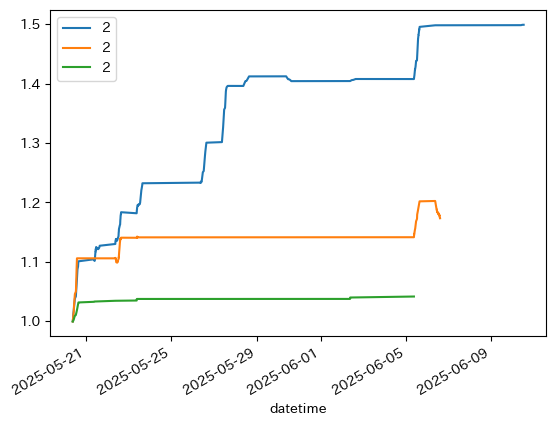

経過時間: 1.48 分


In [8]:
import time as time_module
start = time_module.perf_counter()
lis = [];results_df=pd.DataFrame()
sharp_ratio1 = -np.inf
import sys
for minute in [5]:
    for threshold in [50]:
        
        for a in [2]:  # 仮のコード
            cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True,)
            numbers = iter(range(20))
            tradecost =0.77*1e-2
            for Tickers in [tickers5[1:], tickers3[1:], tickers4[1:]]:
                num = next(numbers)
                for code in Tickers:
                    
                    if isinstance(code, int):
                        code = str(code) + '.T'
                    try:
                        df = pd.read_csv(f'Price/temp2/{code.replace(".T", "")}.csv', index_col=0, parse_dates=True)
                        df = df.loc['2025-05-01':].interpolate().dropna()
                        for col in ['macdhist','rsi9', 'daily_turnover', 'predicted']:
                            if col not in df.columns:
                                df[col] = 0.0
                        df = preprocess_df(df, exit_minutes=minute)
                        data = SignalData(dataname=df)
                        cerebro.adddata(data, name=code)
                    except Exception as e:
                        print(f"Failed to load {code}: {e}")
                        continue
        
                cerebro.addstrategy(PortfolioStrategy, threshold=threshold, exit_minutes=minute)
                initial_cash = 10_000_000
                cerebro.broker.setcash(initial_cash)
                cerebro.broker.setcommission(commission=tradecost)
        
                print(f'Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}')
                backtest_result = cerebro.run()
                print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
                
                strat = backtest_result[0]
                log_df = pd.DataFrame(strat.trade_log)
                log_df.set_index('datetime', inplace=True)
    
                            
                
                
                # データ読み込みと実行
                df = log_df.reset_index()  # trade_log: すでに存在
                if 'datetime' not in df.columns:
                    df = df.reset_index()  # index が datetime 型ならこれで良い
                df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    
                # 各銘柄ごとに処理
                
                adjusted = df.groupby('symbol', group_keys=False).apply(apply_skip_logic)
                adjusted = adjusted.groupby('symbol', group_keys=False).apply(lambda df:apply_slippage_adjustment(df, alpha=a))
                            
                
                profits = adjusted.dropna(subset=['datetime']) 
    
                # 各時刻ごとに pnl_adj を合計
                datetime_grouped = profits.groupby('datetime')['pnl_adj'].sum().sort_index()

                check_cols = ['price', 'price_prev', 'volume', 'size']
                adjusted[check_cols].describe()
                 # 必要に応じて cerebro.broker.getvalue() 等と整合性を取る
                adjusted['slippage'] = adjusted['pnl'] - adjusted['pnl_adj']
                
                adj_total_pnl = adjusted['pnl_adj'].sum()
                final_value = cerebro.broker.getvalue()
                expected_value = initial_cash + adj_total_pnl
                
                print(f"累積pnl_adj: {adj_total_pnl:,.2f}")
                print(f"スリッページ反映後の期待資産: {expected_value:,.2f}")
                print(f"実際のFinal Portfolio Value: {final_value:,.2f}")
                # Series → DataFrame に変換
                datetime_df = datetime_grouped.reset_index()
                datetime_df = remove_outliers_iqr(datetime_df, 'pnl_adj')
                datetime_df.columns = ['datetime', 'pnl_sum']  # 列名明示
                
                # リターン列を追加（%表示にしたければ * 100）
                datetime_df['return'] = datetime_df['pnl_sum'] / initial_cash
                (1+np.cumsum(datetime_df.set_index('datetime')['return'])).plot(label='{}'.format((a)), legend=True)
                if np.nanstd(datetime_df['return'], ddof=1) == 0:
                    sharp_ratio = np.nan
                    print("⚠️ Sharp ratio not computable")
                else:
                    returns = datetime_df['return']
                    sharp_ratio = np.nanmean(returns) / np.nanstd(returns, ddof=1) * np.sqrt(252)
        
                lis.append((minute, threshold, num, sharp_ratio))
                results_df.loc[threshold, minute] = sharp_ratio
                if sharp_ratio > sharp_ratio1:
                    sharp_ratio1 = sharp_ratio
                # clear_output(wait=True)
                
                with open('temp_Short.txt', 'a') as f:
                    f.write(f"{minute}, {threshold}, {sharp_ratio}, {tradecost}\n")
plt.savefig('0710.png')
plt.show()                


end= time_module.perf_counter()
print(f"経過時間: {(end - start) / 60:.2f} 分")

In [16]:
datetime_df.to_csv('20250710.csv')

In [48]:
datetime_df['hour'] = [x.hour for x in datetime_df['datetime']]
#datetime_df['minute'] = datetime_df['datetime'].minute
for HOUR in range(9, 16):
    print(HOUR)
    print((datetime_df[datetime_df['hour']==HOUR]['pnl_sum']>0).sum() /datetime_df[datetime_df['hour']==9].shape[0])

9
0.7130434782608696
10
0.7391304347826086
11
0.391304347826087
12
0.4
13
0.6956521739130435
14
0.6521739130434783
15
0.3652173913043478


In [51]:
import numpy as np
import pandas as pd

def calculate_underwater(returns: pd.Series) -> pd.Series:
    """
    自前で underwater plot の元データ（ドローダウン率）を計算
    """
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    underwater = cum_returns / peak - 1
    return underwater
import numpy as np
import pandas as pd

def calculate_underwater(returns: pd.Series) -> pd.Series:
    """
    自前で underwater plot の元データ（ドローダウン率）を計算
    """
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    underwater = cum_returns / peak - 1
    return underwater
underwater = calculate_underwater(returns)

if (underwater == 0).any():
    pf.plot_drawdown_periods(returns=returns, ax=axes[0])
else:
    print("No drawdown periods detected.")

plt.plot(np.cumsum(returns.values))

NameError: name 'pf' is not defined

In [7]:
dfY = df
dfY['year'] = dfY.index.year
dfY['month'] = dfY.index.month
table = {}
pd.set_option('display.max_rows', 20)
start = 2014
for year in range(start, 2023, 1):

    dfZ = dfY.query('year==@year')
    Max_asset = dfZ[['open_price']].max()
    Sum_profit = dfZ['interest'].sum()
    Return = Sum_profit / Max_asset.values
    #table[str(year+1)+ '.3'] = Max_asset
    table[str(year+1)+ '.3'] = Return
pd.DataFrame.from_dict(table, orient='index')

NameError: name 'df' is not defined

In [ ]:
def Evaluation(df):
    Sel = pd.Series()
    #Sel['初期資金'] = df['open_price'][0]

    Sel["全トレード数"] = df.shape[0]
    #print((10**2) * df.query('interest >= 0').count() / df.shape[0])
    Sel["勝率"] = "{:.2f}%".format((10**2) * df.query('Return >= 0').shape[0] / df.shape[0])
    Sel["負率"] = "{:.2f}%".format((10**2)* df.query('Return < 0').shape[0] / df.shape[0])
    Sel["全トレード平均利益"] = df['Return'].mean()
    Sel["勝ちトレード平均利益"] =  df.query('Return >= 0')['Return'].mean()
    Sel["負けトレード平均利益"] =  df.query('Return < 0')['Return'].mean()
    
    Sel["プロフィットファクター"] = df.query('Return >= 0')['Return'].sum() / -df.query('Return < 0')['Return'].sum()
    
    display(pd.DataFrame(Sel))
    fig, ax = plt.subplots()
    ax.hist(df['Return'], bins=20, label='Return')
    return
Evaluation(df.query('signal==0'))